In [41]:
import numpy as np
import pandas as pd
import seaborn as sns

import geopandas as gpd
import shapely
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from sklearn.neighbors import KNeighborsRegressor

Ex. 7.1.1

In [26]:
coords = [(2,2), (2,5), (5,5), (5,2), (2,2)]
square = Polygon(coords)

coords = [(0,0),(4,0),(2,4)]
triangle = Polygon(coords)

Ex. 7.1.2

In [27]:
diff = square.difference(triangle)

union = square.union(triangle)

Ex. 7.1.3

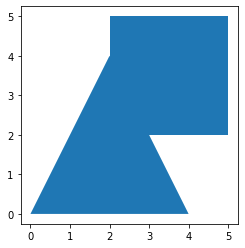

In [28]:
gpd.GeoSeries([square, triangle]).plot()

Ex. 7.2.1

In [29]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
kommuner.head()

,KOMKODE,KOMNAVN,geometry
0,0766,Hedensted,"POLYGON Z ((9.44919 55.86046 -999.00000, 9.460..."
1,0766,Hedensted,"POLYGON Z ((10.06198 55.83301 -999.00000, 10.0..."
2,0561,Esbjerg,"POLYGON Z ((8.59656 55.53506 -999.00000, 8.601..."
3,0849,Jammerbugt,"POLYGON Z ((9.78314 57.07319 -999.00000, 9.781..."
4,0849,Jammerbugt,"POLYGON Z ((9.19738 57.13868 -999.00000, 9.207..."


The Coordinate Reference System (CRS) relates the coordinates (otherwise in an arbitrary space) to the actualgeographical location. The CRS used here by default is the WGS 84, which is one of the most commonly used. The coordinates are in decimal degrees; latitudes and longitudes. It can be referred to using the authority code "EPSG:4326" - it's the world. It has projected bounds (-180, -90, 180, 90).

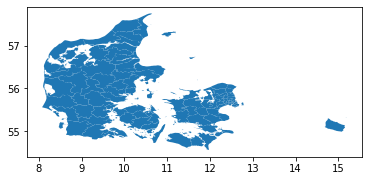

In [30]:
kommuner.crs
kommuner.plot()

Re-projecting the coordinate system to one with metre as unit:

/Users/karlbindslev/.conda/envs/SDS_Econometrics_ML/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


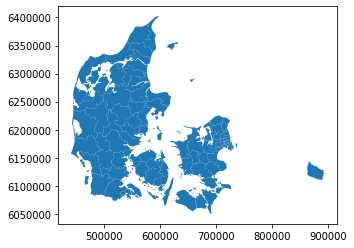

In [31]:
kommuner.to_crs({'init':'epsg:25832'}, inplace=True) # European map, unit: metre
kommuner.crs
kommuner.plot()

Which three munipalities have the largest area?

In [32]:
tot_area = kommuner.groupby('KOMNAVN').geometry.apply(lambda d: d.unary_union.area)

tot_area.nlargest(3)

KOMNAVN
Ringkøbing-Skjern    1.494151e+09
Viborg               1.419631e+09
Herning              1.323127e+09
Name: geometry, dtype: float64

Code block from exercise description:

In [33]:
kommuner.columns = kommuner.columns.str.lower()
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner').pipe(lambda df: df.assign(komkode=df.kode.astype(str).str.zfill(4))).loc[:, ['komkode', 'regionskode']]
region_info = pd.read_json('https://dawa.aws.dk/regioner/').loc[:, ['kode', 'navn']].add_prefix('regions')
kommuner = kommuner.merge(kommune_info, how='left').merge(region_info, how='left')

Ex. 7.2.2

In [34]:
kommuner['Hovedstad_Sjælland_dummy'] = kommuner['regionsnavn'].isin(['Region Hovedstaden', 'Region Sjælland'])
kommuner['not_Bornholm_dummy'] = ~kommuner['komnavn'].isin(['Bornholm', 'Christiansø'])

kommuner['Sjæland_dummy'] = kommuner['Hovedstad_Sjælland_dummy'] & kommuner['not_Bornholm_dummy']
sealand = kommuner[kommuner['Hovedstad_Sjælland_dummy'] & kommuner['not_Bornholm_dummy']]

Ex. 7.2.3

In [35]:
max = kommuner[kommuner['Sjæland_dummy']==True].bounds.max()
min = kommuner[kommuner['Sjæland_dummy']==True].bounds.min()

maxx = max[2]
maxy = max[3]
minx = min[0]
miny = min[1]
print(maxx, maxy, minx, miny)

739259.9999965408 6231607.999993474 617288.0000000043 6049781.999990507


Ex. 7.2.4

In [36]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.

    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)
    y : str
        Name of the vertical coordinate (~latitude)
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''

    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left
        coordinates to a polygon.

        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.

        Returns
        ----------
        poly: shapely.Polygon

        '''

        square_coords = ((row[x], row[y]),
                         (row[x] + dist, row[y]),
                         (row[x] + dist, row[y] + dist),
                         (row[x], row[y] + dist))

        poly = shapely.geometry.Polygon(square_coords)

        return poly

    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)

    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)

    return square_gdf

/Users/karlbindslev/.conda/envs/SDS_Econometrics_ML/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+proj=utm +ellps=GRS80 +no_defs +units=m +zone=32 +type=crs != +init=epsg:25832 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


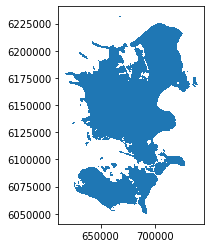

In [37]:
grid_coordinates = [(x,y) for x in np.arange(minx, maxx, 500)
                            for y in np.arange(miny, maxy, 500)]

grid_df = pd.DataFrame(data=grid_coordinates, columns = ['e','n'])
grid_df = cell_coords_to_polygons(grid_df)

square_map = gpd.sjoin(grid_df, sealand)
square_map.plot()

Ex. 7.2.4

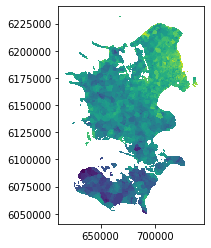

In [42]:
price_gdf = gpd.read_file('houseprices.GeoJSON')

price_gdf.head()

years = np.unique(price_gdf['sale_year'])

for year in years:
    yearly_sales = price_gdf[(price_gdf['price_area'].between(1000, 120000)) & (price_gdf['sale_year'] == year)]
    yearly_sales = yearly_sales[['sale_year','e','n','price_area']]
    yearly_sales = yearly_sales.dropna()

    X = yearly_sales[['e', 'n']]
    y = yearly_sales['price_area']
    KN = KNeighborsRegressor()
    KN.fit(X, y)

    X_center = square_map[['e','n']] +250

    preds = KN.predict(X_center)

    #year_string = 'p_{}'.format(year)
    square_map['p_{}'.format(year)] = np.log10(preds)

square_map.plot(column='p_2012')